<a href="https://colab.research.google.com/github/AmedeeRoy/BirdGAN/blob/master/code/2_gan_vs_hmm_200_steps_SV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GAN

In [1]:
# mount google drive
from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
%cd drive/My\ Drive/

/content/drive/My Drive


## load data

In [299]:
from utils.tools import *

In [222]:
# import python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
import time

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset
import torchvision as tv
from torchsummary import summary

In [3]:
# data = pd.read_table('./data/trips_SV_200_steps.csv', sep = ',')
data = pd.read_csv("../../Minute_Trajectories.csv")
# data['datetime'] = pd.to_datetime(data['datetime'], format='%Y-%m-%d %H:%M:%S')

# colony = (-77.264, -11.773)
# colony =  (-32.392, -3.819)
# scale = 5e4

# data = format_data(data, colony, scale)
# data = data[data.dist_colony > 1000]

# padding = 200
# traj = padding_data(data, padding)

# print('range : \nmin : ' + str(np.min(traj)) + '\nmax : ' + str(np.max(traj)))

In [4]:
print(data.keys())


Index(['minute_id', 'x', 'y', 't', 'id', 'dFrames', 's', 'v', 'a', 'disp',
       'theta', 'alpha', 'sin', 'cos', 'adist', 'wall', 'startDisp', 'endDisp',
       'antennaLx', 'antennaLy', 'antennaRx', 'antennaRy', 'legLx', 'legLy',
       'legRx', 'legRy', 'sub_traj_id'],
      dtype='object')


In [13]:
print(np.shape(data))
print(3559500/1500)

(3559500, 27)
2373.0


In [263]:
def build_data_ants(data):
    d = {}
    d['step_distance'] = data['disp']
    d['step_direction'] = data['alpha']
    
    return d

def padding_data(data):
    traj_all = np.zeros((2373, 2, 1500))
    i=0
    for tt in range(2373):
        traj = data[data['minute_id'] == tt+1].copy()
        initx = traj['x'].to_numpy()[0]
        inity = traj['y'].to_numpy()[1]
        coord = traj[['x','y']].to_numpy()
        coord = coord[np.arange(0, coord.shape[0]),:]
        coord[:,0] = coord[:,0]-initx
        coord[:,1] = coord[:,1]-inity

        traj_all[i, 0, :] = coord[:,0]
        traj_all[i, 1, :] = coord[:,1]
        # traj_all[i, 2, :coord.shape[0]] = coord[:,2]
        i += 1
    print(np.shape(traj_all[:,0,:].flatten()))
    maxx = max(traj_all[:,0,:].flatten())
    maxy = max(traj_all[:,1,:].flatten())
    traj_all[:,0,:] = traj_all[:,0,:]/maxx
    traj_all[:,1,:] = traj_all[:,1,:]/maxy
    return traj_all


In [264]:
traj = padding_data(data)

(3559500,)


In [265]:
print(np.shape(traj))

(2373, 2, 1500)


In [266]:
class TrajDataSet(Dataset):
    def __init__(self,  traj, transform=None):
        self.traj = traj
        self.transform = transform

    def __len__(self):
        return self.traj.shape[0]

    def __getitem__(self, idx):
        # select coordinates
        sample = self.traj[idx,:,:]
        if self.transform:
            sample = self.transform(sample)

        return sample

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""
    def __call__(self, sample):
        return torch.FloatTensor(sample)

In [267]:
# hyperparameters
batch_size = 25
resolution = 60

## reduce size dataset
train_set = TrajDataSet(traj, transform= ToTensor())

train_loader = DataLoader(train_set, batch_size=batch_size, num_workers = 0, shuffle = True, drop_last=False)

In [268]:
x =  next(iter(train_loader))

In [269]:
len(train_set)

2373

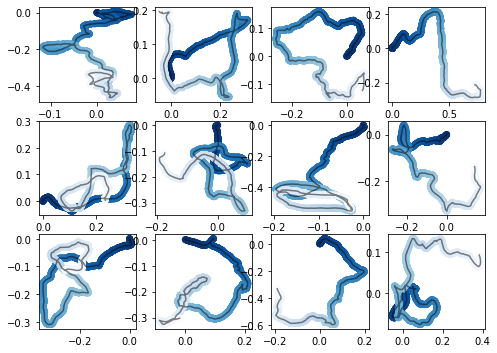

In [270]:
plt.figure(figsize = (8,8))
i = 4
padding=1500
for i in range(12):
    plt.subplot(4,4,i+1)
    plt.plot(x.numpy()[i,0,:], x.numpy()[i,1,:], c = 'black', alpha = 0.5)
    plt.scatter(x.numpy()[i,0,:], x.numpy()[i,1,:], c=np.arange(padding), cmap='Blues_r')
#     plt.scatter(0,0, c = 'red')
#     plt.xlim(-1,1)
#     plt.ylim(-1,1)


## deep networks

Architecture guidelines for stable Deep Convolutional GANs (Radford et al. 2016)

- Replace any pooling layers with strided convolutions (discriminator) and fractional-strided
convolutions (generator).
- Use batchnorm in both the generator and the discriminator.
- Remove fully connected hidden layers for deeper architectures.
- Use ReLU activation in generator for all layers except for the output, which uses Tanh.
- Use LeakyReLU activation in the discriminator for all layers.



In [271]:
import torch
from torch import nn
from torch import optim
import torchvision as tv
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

In [272]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [273]:
class CNNGenerator(nn.Module):
    def __init__(self):
        super().__init__()

        self.cnn = nn.Sequential(    
            nn.ConvTranspose1d(256, 128, kernel_size = 150, stride = 2, padding = 15, bias = False),
            nn.BatchNorm1d(128),
            nn.ReLU(True),

            nn.ConvTranspose1d(128, 32, kernel_size = 100, stride = 2, padding = 15, bias = False),
            nn.BatchNorm1d(32),
            nn.ReLU(True),

            nn.ConvTranspose1d(32, 8, kernel_size = 100, stride = 2, padding = 6, bias = False),
            nn.BatchNorm1d(8),
            nn.ReLU(True),

            nn.ConvTranspose1d(8, 2, kernel_size = 100, stride = 2, padding = 1, bias = False),
            nn.Tanh()
         )

    def forward(self, z):    
        out = self.cnn(z)

        return out

In [274]:
z = torch.rand((batch_size, 256, 1), device = device)
gen = CNNGenerator().to(device)
gen(z).shape

torch.Size([25, 2, 1500])

In [275]:
summary(gen, (256, 25))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose1d-1             [-1, 128, 168]       4,915,200
       BatchNorm1d-2             [-1, 128, 168]             256
              ReLU-3             [-1, 128, 168]               0
   ConvTranspose1d-4              [-1, 32, 404]         409,600
       BatchNorm1d-5              [-1, 32, 404]              64
              ReLU-6              [-1, 32, 404]               0
   ConvTranspose1d-7               [-1, 8, 894]          25,600
       BatchNorm1d-8               [-1, 8, 894]              16
              ReLU-9               [-1, 8, 894]               0
  ConvTranspose1d-10              [-1, 2, 1884]           1,600
             Tanh-11              [-1, 2, 1884]               0
Total params: 5,352,336
Trainable params: 5,352,336
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forw

In [276]:
class CNNDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()
                
        self.cnn = nn.Sequential(
            nn.Conv1d(2, 8, kernel_size = 4, stride = 3, padding = 0, bias = False),
            nn.BatchNorm1d(8),
            nn.LeakyReLU(0.2, inplace=False),

            nn.Conv1d(8, 32, kernel_size = 4, stride = 5, padding = 1, bias = False),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.2, inplace=False),

            nn.Conv1d(32, 128, kernel_size = 4, stride = 4, padding = 1, bias = False),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2, inplace=False),

            nn.Conv1d(128, 1, kernel_size=25, stride=4, padding=0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        out = self.cnn(x)
        return out.squeeze(1)

In [277]:
dis = CNNDiscriminator().to(device)
dis(x.to(device)).shape

torch.Size([25, 1])

# training

In [278]:
def weights_init(m):
    """
    This function initializes the model weights randomly from a 
    Normal distribution. This follows the specification from the DCGAN paper.
    https://arxiv.org/pdf/1511.06434.pdf
    Source: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
    """
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [279]:
generator = CNNGenerator().to(device)
discriminator = CNNDiscriminator().to(device)

### WEIGHT INITIALIZATION
generator.apply(weights_init)
discriminator.apply(weights_init)

criterion = nn.BCELoss()

lr = 0.0002
optim_d = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
optim_g = optim.Adam(generator.parameters(),lr= lr, betas=(0.5, 0.999))

In [280]:
def periodogram(tt):
  periodogram = torch.mean(torch.fft.fft(tt, 200).abs(), 0)
  return torch.log(periodogram)

In [281]:
# Train the model
nb_epoch = 25

time_start = time.perf_counter()
epoch = 0
for i in tqdm(range(nb_epoch)):
    epoch +=1
    loss_g_running, loss_d_real_running, loss_d_fake_running = 0, 0, 0
    for batch, x in enumerate(train_loader):
        
        #### TRAIN DISCRIMINATOR
        ## true samples
        x = x.to(device)
        batch_size = x.shape[0]

        target_ones = torch.ones((batch_size, 1), device=device)
        target_zeros = torch.zeros((batch_size, 1), device=device)

        discriminator.zero_grad()
        pred_real = discriminator(x)
        loss_real = criterion(pred_real, target_ones)

        ## false samples
        z = torch.randn((batch_size, 256, 1), device=device)
        with torch.no_grad():
            fake_samples = generator(z)
        pred_fake = discriminator(fake_samples)
        loss_fake = criterion(pred_fake, target_zeros)
        
        # combine
        loss = (loss_real + loss_fake) / 2
        loss.backward()
        optim_d.step()

        loss_d_real_running += loss_real.item()
        loss_d_fake_running += loss_fake.item()

        #### TRAIN GENERATOR
        generator.zero_grad()
        z = torch.randn((batch_size, 256, 1), device=device)

        generated = generator(z)
        classifications = discriminator(generated)
        loss = criterion(classifications, target_ones) +  10*torch.mean((periodogram(generated) - periodogram(x))**2)
        loss.backward()
        optim_g.step()

        loss_g_running += loss.item()   

    if epoch%500 == 0:
        print('\nEpoch [{}/{}] -----------------------------------------------------------------------------'
            .format(epoch+1, nb_epoch, i, len(train_loader)))
        print('G: {}, Dr : {}, Df : {}'
            .format(np.round(loss_g_running/batch_size, 2), np.round(loss_d_real_running/batch_size, 2), np.round(loss_d_fake_running/batch_size, 2)))
        
        nb = 16
        z = torch.randn((nb, 256, 1), device=device)
        with torch.no_grad():
          generated = generator(z)
        
        traj_sim = generated.cpu().detach().numpy()

        plt.figure(figsize = (8,8))

        for i in range(16):
          plt.subplot(4,4,i+1)
          plt.plot(traj_sim[i,0,:], traj_sim[i,1,:], c = 'black', alpha = 0.5)
          plt.scatter(traj_sim[i,0,:], traj_sim[i,1,:], c=np.arange(padding), cmap='Blues_r')
          plt.scatter(0,0, c = 'red')
          plt.xlim(-2,2)
          plt.ylim(-2,2)

        plt.show()
        plt.close()

100%|██████████| 25/25 [15:50<00:00, 38.03s/it]


In [282]:
nb = 100
z = torch.randn((100, 256, 1), device=device)
with torch.no_grad():
  generated = generator(z)

traj_sim = generated.cpu().detach().numpy()

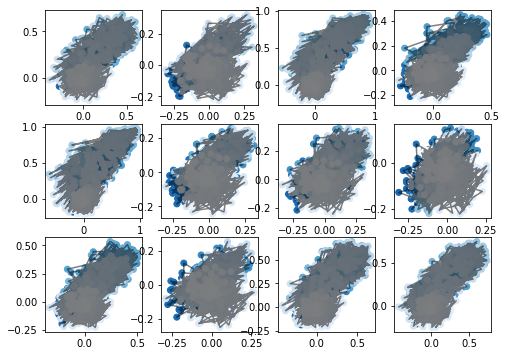

In [286]:
plt.figure(figsize = (8,8))
i = 4
padding=1500
for i in range(12):
    plt.subplot(4,4,i+1)
    plt.plot(generated[i,0,:], generated[i,1,:], c = 'black', alpha = 0.5)
    plt.scatter(generated[i,0,:], generated[i,1,:], c=np.arange(padding), cmap='Blues_r')
#     plt.scatter(0,0, c = 'red')
#     plt.xlim(-1,1)
#     plt.ylim(-1,1)


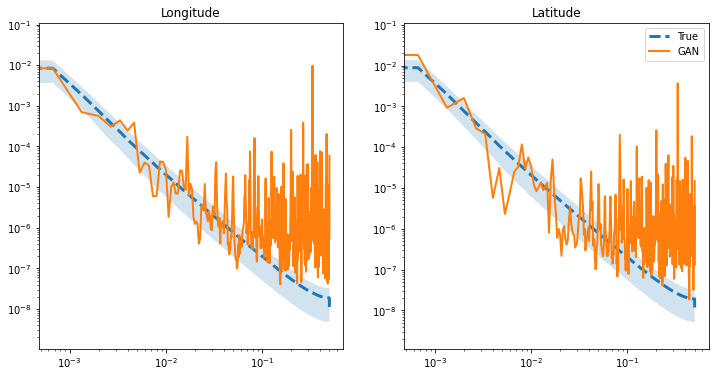

11.83213717719388

In [284]:
get_score(traj, traj_sim, plot=True)

In [292]:
data_fake = format_simulation(traj_sim, [0,0], 1)
data_fake = data_fake[data_fake.dist_colony > 1000]



In [301]:
# get_distribution(data, data_fake)
# plt.show()
# plt.close()

In [294]:
torch.save(generator, 'SV_200_steps_G.pt')
torch.save(discriminator, 'SV_200_steps_D.pt')

# generator = torch.load('basicGAN_cnn_G_SD.pt')
# discriminator = torch.load('basicGAN_cnn_D_SD.pt')